# Introduction

So we've just compared 2 programming languages and environments (C# in VS and Java in Eclipse). For the total task time, it's taken 20 students using each of those tools to write a series of small programs as a part of an intro to programming class. We found that VS was significantly faster according to the statistical test that we did. 

What happens now if we add a 3rd programming environment? We no long can use an independent samples T-test (or the Mann-Whitney U test) when we have 3 levels together. 

Let's say that the 3rd level is the Python programming language and the PyCharm programming environment. This will bring us to a very powerful and widely used test, the F-Test. And in this cae, it arises in the context of what's called a one-way ANOVA. Again, ANOVA stands for Analysis of Variance. One-way refers to a single factor in that analysis. And that factor is IDE and has 3 levels (VS, Eclipse, and PyCharm). 

# Analyzing and reporting a one-way ANOVA

We're moving to 3 levels (which will require that we use a one-way ANOVA). 

In [24]:
# one way ANOVA

ide3 <- read.csv("materials/ide3.csv")
ide3$Subject <- as.factor(ide3$Subject)
summary(ide3)

    Subject        IDE          Time      
 1      : 1   Eclipse:20   Min.   :143.0  
 2      : 1   PyCharm:20   1st Qu.:248.8  
 3      : 1   VStudio:20   Median :295.0  
 4      : 1                Mean   :353.9  
 5      : 1                3rd Qu.:391.2  
 6      : 1                Max.   :952.0  
 (Other):54                               

In [25]:
# view descriptive statistics by IDE
library("plyr")

In [26]:
ddply(ide3, ~ IDE, function(data) summary(data$Time))

IDE,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
Eclipse,232,294.75,393.5,468.15,585.50,952
PyCharm,143,232.25,279.5,291.45,300.00,572
VStudio,155,246.50,287.0,302.10,335.25,632


In [27]:
ddply(ide3, ~ IDE, summarise, Time.mean = mean(Time), Time.sd = sd(Time))

IDE,Time.mean,Time.sd
Eclipse,468.15,218.1241
PyCharm,291.45,106.8922
VStudio,302.10,101.0778


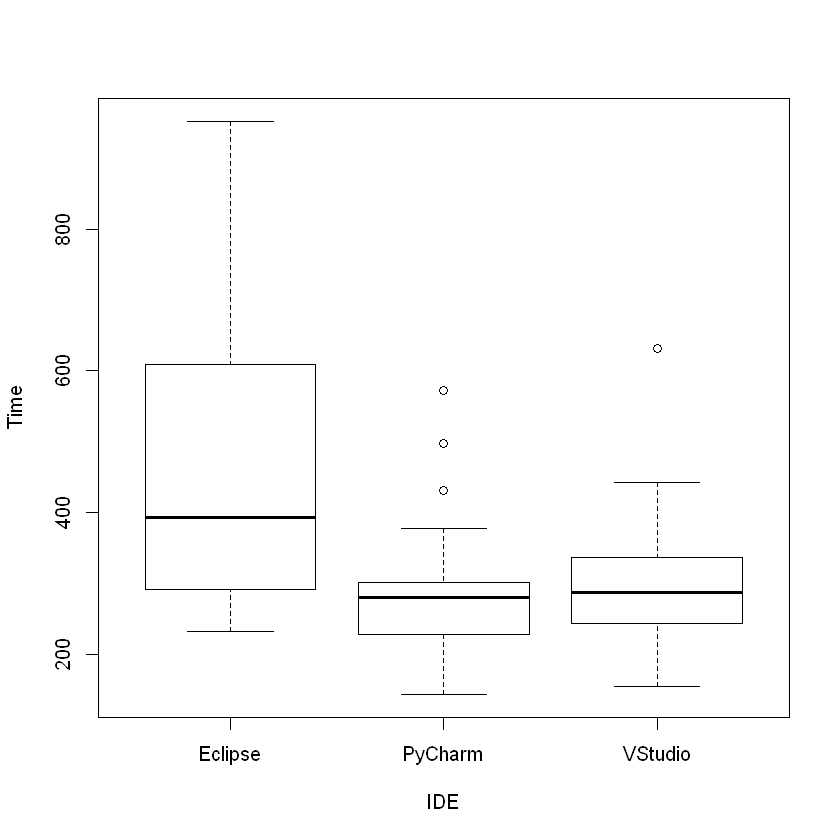

In [28]:
# explore the new response distribution
VS <- ide3[ide3$IDE == "VStudio",]
Eclipse <- ide3[ide3$IDE == "Eclipse",]
PyCharm <- ide3[ide3$IDE == "PyCharm",]

plot(Time ~ IDE, ide3)

We can see that the times for VS and Eclipse haven't changed. The histogram for PyCharm is new and we can see there were quite a few students who took between 200 and 300 minutes for these programs. And a boxplot now compares all three. Looks like PyCharm might have a little edge on VS and both look like they were faster to do than Eclipse. 

As we did before, we'll test for normality on the result of this time of the new level of PyCharm

In [29]:
# test for normality for the new IDE
shapiro.test(PyCharm$Time)


	Shapiro-Wilk normality test

data:  PyCharm$Time
W = 0.88623, p-value = 0.02294


The p-value is significant so we have a departure from normality. But we should also test it on the residuals as it's more proper. So we fit our model and test the residuals.

In [30]:
m <- aov(Time ~ IDE, data=ide3) # fit model
residuals_m <- residuals(m) # residuals
shapiro.test(residuals_m) # test the residuals for normality


	Shapiro-Wilk normality test

data:  residuals_m
W = 0.89706, p-value = 0.000103


Again, the p-value was lower than 0.05 so it's significant. And thus, we see a departure from normality. Let's take a look at the qqplots

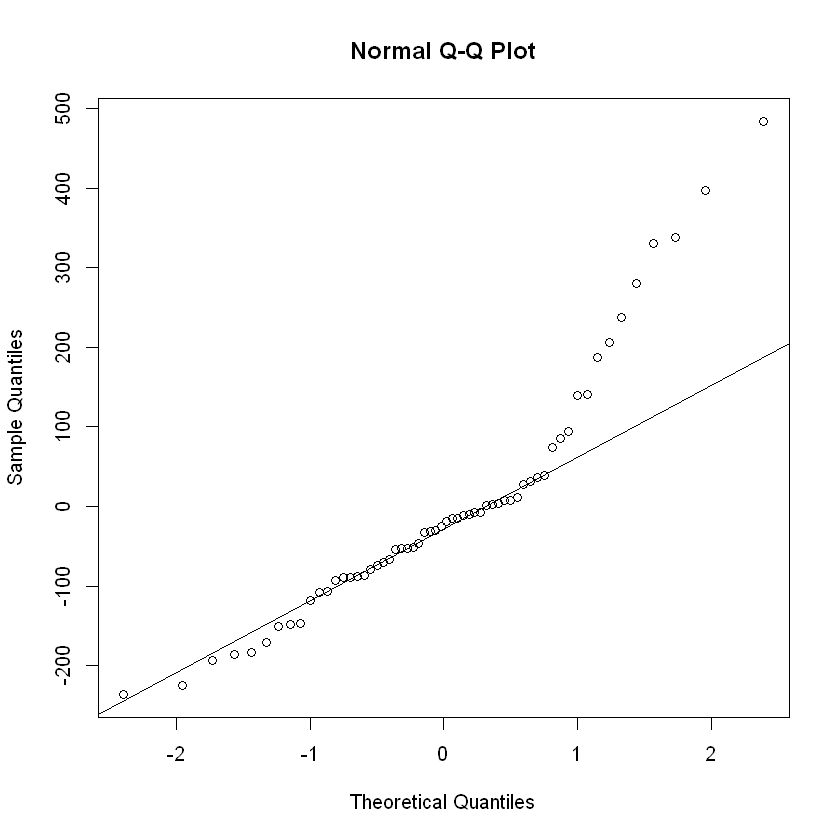

In [31]:
qqnorm(residuals_m);
qqline(residuals_m) 

We can test lognormality as we did before of the PyCharm level. We already did it previously on VS and Eclipse. 

In [32]:
# test for lognormality of the new IDE (PyCharm)
library("MASS")

fit <- fitdistr(PyCharm$Time, "lognormal")$estimate
print(fit)

ks.test(PyCharm$Time, "plnorm", 
           meanlog=fit[1], 
           sdlog=fit[2],
           exact=TRUE) # lognormality

  meanlog     sdlog 
5.6176131 0.3329282 



	One-sample Kolmogorov-Smirnov test

data:  PyCharm$Time
D = 0.1864, p-value = 0.4377
alternative hypothesis: two-sided


And the lognormality test with the KS test shows that we're not statististically significant in a departure from lognormality. Because the p-value is greater than 0.05, we fail to reject the null hypothesis that it is lognormal. So this gives us an indication that the PyCharm times may be lognormally distributed. So let's create the LogTime column. 

In [33]:
# compute logTime and re-test

ide3$logTime <- log(ide3$Time)
summary(ide3)

    Subject        IDE          Time          logTime     
 1      : 1   Eclipse:20   Min.   :143.0   Min.   :4.963  
 2      : 1   PyCharm:20   1st Qu.:248.8   1st Qu.:5.516  
 3      : 1   VStudio:20   Median :295.0   Median :5.687  
 4      : 1                Mean   :353.9   Mean   :5.780  
 5      : 1                3rd Qu.:391.2   3rd Qu.:5.969  
 6      : 1                Max.   :952.0   Max.   :6.859  
 (Other):54                                               

In [34]:
PyCharm <- ide3[ide3$IDE == "PyCharm", ]

shapiro.test(PyCharm$logTime)


	Shapiro-Wilk normality test

data:  PyCharm$logTime
W = 0.96579, p-value = 0.6648


The p-value is greater than 0.05 so we fail to reject the null hypothesis that it is normally distributed. 

In [35]:
m <- aov(logTime ~ IDE, data=ide3)
residuals_m <- residuals(m)
shapiro.test(residuals_m)


	Shapiro-Wilk normality test

data:  residuals_m
W = 0.96563, p-value = 0.08893


The p-value here is also greater than 0.05 so we fail to reject the null hypothesis that it is normally distributed. It's close to 0.05 so it's nearly a departure from normality but not quite. So we'll proceed with some confidence there since ANOVA is somewhat robust to milk departures anyway. 

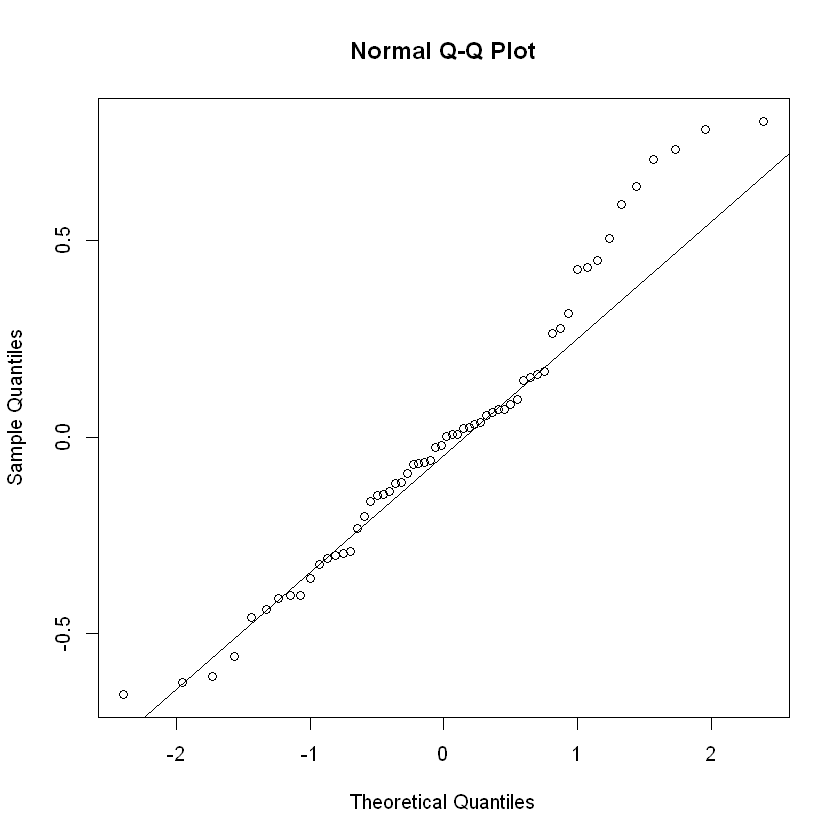

In [36]:
qqnorm(residuals_m); 
qqline(residuals_m)

We'll also do our homscedasticity test with Lavine's test (the Brown-Forsythe version)

In [37]:
library("car")

In [38]:
leveneTest(logTime ~ IDE, data=ide3, center=median) #Brown-Forsythe test

,Df,F value,Pr(>F)
group,2,1.779692,0.1779353
,57,NA,NA


The p-value is greater than 0.05 so we fail to reject the null hypothesis that it is homoscedastic. So that means that we don't have a violation with our logTime result. Our variances are similar enough. So now, we're going to fit the actual one way ANOVA. 

In [39]:
# one-way ANOVA, suitable now to logTime

m <- aov(logTime ~ IDE, data=ide3) # fit model
anova(m) # report anova

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
IDE,2,2.306375,1.1531876,8.796025,0.0004684851
Residuals,57,7.472886,0.1311033,NA,NA


We fit the model and then we use the ANOVA command to calculate and report the ANOVA. Again, we see the F-value of 8.796. The p-value is much less than 0.05. We reject the null hypothesis that there is not variance among the 3 levels. What that means is the overall ANOVA or the omnibus test (as it's called) shows that there's some difference among these levels of IDE. It does not tell us exactly what the difference is, nor does it tell us where exactly the difference lies in terms of comparisons between each of these IDEs...so we have to look further. 

But that first test being significant gives us permission to do what are called post-hoc tests, meaning follow-up tests that are pairwaise comparisons that will tell us where those differences lie. So now, we can go back to an independent samples T-Test, between the levels of Eclipse, PyCharm, and VS to see which 2 are different. 

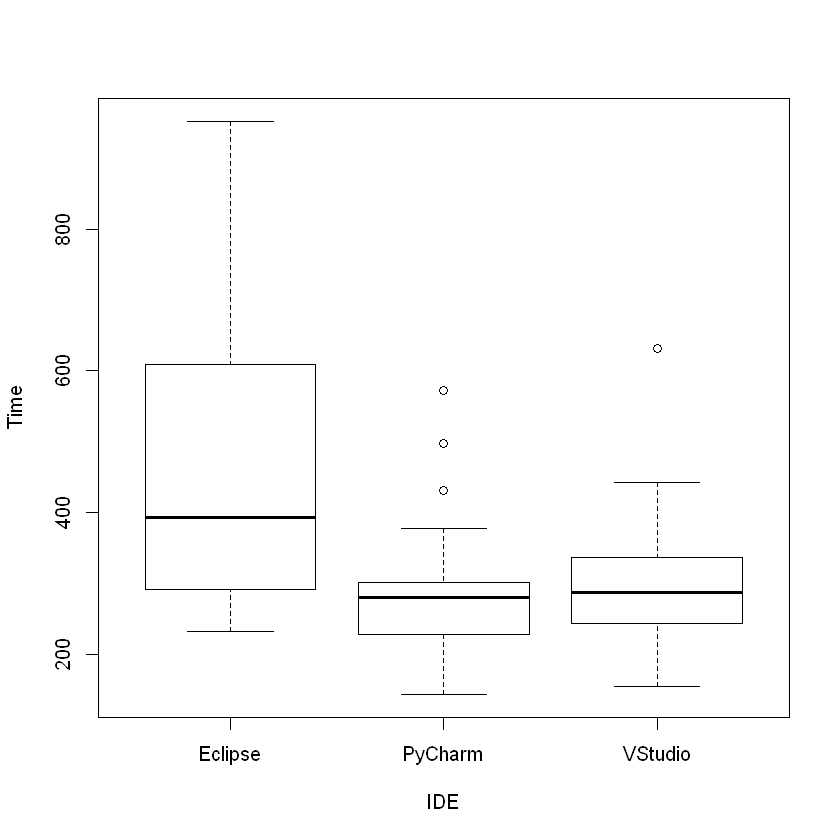

In [40]:
# post hoc independent-samples t-tests
plot(Time ~ IDE, data=ide3)

And just looking at the graph, we might ask, is PyCharm different from VS? Because those are the ones that obviously look close together. The eclipse level being so different is reason enough for the overal F test to be significant. 

In [41]:
library("multcomp")

In [42]:
(gen_linear_hyp <- glht(m, mcp(IDE="Tukey"))) # Tukey means compare all pairs


	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                       Estimate
PyCharm - Eclipse == 0  -0.4380
VStudio - Eclipse == 0  -0.3895
VStudio - PyCharm == 0   0.0485


The GLHT command is doing the test for us and the MCP is a command for multiple comparisons. We say which factor we're testing over. We have one IDE with 3 levels. When we say Tukey, it's a shorthand for all pairwise comparisons. As we've done before, we're adjusting for multiple test because they all by chance have a 1 in 20 chance of being significant. So we adjust with Holm Sequential Bonferroni procedure, which accounts for the factor making multiple comparison so we don't get an inflated chance of seeing significance where there isn't any. 

In [43]:
summary(gen_linear_hyp, test=adjusted(type="holm")) 


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = logTime ~ IDE, data = ide3)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
PyCharm - Eclipse == 0  -0.4380     0.1145  -3.826 0.000978 ***
VStudio - Eclipse == 0  -0.3895     0.1145  -3.402 0.002458 ** 
VStudio - PyCharm == 0   0.0485     0.1145   0.424 0.673438    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- holm method)


We can see our pairwise values. PyCharm vs Eclipse is significantly different and we can see PyCharm is faster. VS vs. Eclipse, we found from before and that hasn't changed. And then VS vs. PyCharm's p-value is 0.67. So these are not detectably different according to this test. 

Just a matter of completeness in R, I will show another way to use the GLHT command. This time with LSM command which allows us to specify that we want pair-wise comparison. This is another way of executing exactly the same result and you may find a value.

In [44]:
# note: equivalent to this using lsm instead of mcp
library("lsmeans")

(lsm_pair <- lsm(pairwise ~ IDE))

[[1]]
pairwise ~ IDE

attr(,"class")
[1] "emmlf"

In [45]:
(gen_linear_hyp <- glht(m, lsm_pair))


	 General Linear Hypotheses

Linear Hypotheses:
                       Estimate
Eclipse - PyCharm == 0   0.4380
Eclipse - VStudio == 0   0.3895
PyCharm - VStudio == 0  -0.0485


We see all the 

In [46]:
summary(gen_linear_hyp, test=adjusted(type="holm"))


	 Simultaneous Tests for General Linear Hypotheses

Fit: aov(formula = logTime ~ IDE, data = ide3)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Eclipse - PyCharm == 0   0.4380     0.1145   3.826 0.000978 ***
Eclipse - VStudio == 0   0.3895     0.1145   3.402 0.002458 ** 
PyCharm - VStudio == 0  -0.0485     0.1145  -0.424 0.673438    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- holm method)


# Kruskal-Wallis - Nonparametric One-way ANOVA

What would be the non-parametric equivalent of a one-way ANOVA. The nonparametric version of the test that we just did with these 3 levels? For that, we'll use a test called the Kruskal Wallace test. We'll load it from the coin library. And in much the same way we specify our model here with our data table. And you can't do an exact test with Kruskal-Wallace if you have 3 levels. So we make explicit asumptotic here. 

In [62]:
## Nonparametric equivalent of one-way ANOVA

# Kruskal-Wallace test
library("coin")

kruskal_test(Time ~ IDE, data=ide3, distribution="asymptotic") # can't do exact with 3 levels


	Asymptotic Kruskal-Wallis Test

data:  Time by IDE (Eclipse, PyCharm, VStudio)
chi-squared = 12.17, df = 2, p-value = 0.002277


We see that we get a p-value of 0.002. So we have significance there. 

In [63]:
kruskal_test(logTime ~ IDE, data=ide3, distribution="asymptotic") # same result


	Asymptotic Kruskal-Wallis Test

data:  logTime by IDE (Eclipse, PyCharm, VStudio)
chi-squared = 12.17, df = 2, p-value = 0.002277


Notice that if we do it on logTime, we get the same result because it is a rank based test. These are reported as chi squared tests. You can get the n which goes into how you report a chi-squared using the nrow() command. 

In [64]:
# for reporting Kruskal-Wallis as chi-square, we can get N with nrow(ide3)

Let's follow up with the post-hoc pairwise comparisons. We can use the Mann Whitney test. 

In [53]:
VS <- ide3[ide3$IDE == "VStudio",]
Eclipse <- ide3[ide3$IDE == "Eclipse",]
PyCharm <- ide3[ide3$IDE == "PyCharm",]

In [55]:
# manual post-hoc Mann-Whitney U pairwise comparisons
# note that wilcox_test we used above doesn't take 2 data vectors so we use wilcox.test

(vs.ec <- wilcox.test(VS$Time, Eclipse$Time, exact=FALSE))
(vs.py <- wilcox.test(VS$Time, PyCharm$Time, exact=FALSE))
(ec.py <- wilcox.test(Eclipse$Time, PyCharm$Time, exact=FALSE))


	Wilcoxon rank sum test with continuity correction

data:  VS$Time and Eclipse$Time
W = 91, p-value = 0.003333
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  VS$Time and PyCharm$Time
W = 220.5, p-value = 0.5885
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  Eclipse$Time and PyCharm$Time
W = 312, p-value = 0.002561
alternative hypothesis: true location shift is not equal to 0


In [65]:
p.adjust(c(vs.ec$p.value, vs.py$p.value, ec.py$p.value), method="holm")

[1] 0.007681846 0.588488864 0.007681846

So we have significant difference for VS vs. Eclipse, as we'd expect. For the third one (Eclipse vs. PyCharm), there's also a significant differnce. But no significant diference between VS and PyCharm. So our conclusion with a non-parametric test is the same. For completeness, I include another way of doing non-parametric pairwise comparisons from the PMCMR libary. You can look into that if you want more background. 

In [66]:
# alternative approach is using PMCMR for nonparam pairwise comparisons
library(PMCMR)
posthoc.kruskal.conover.test(Time ~ IDE, data=ide3, p.adjust.method="holm") # Conover & Iman (1979)

Warning message in posthoc.kruskal.conover.test.default(c(341L, 291L, 283L, 155L, :
"Ties are present. Quantiles were corrected for ties."


	Pairwise comparisons using Conover's-test for multiple	
                         comparisons of independent samples 

data:  Time by IDE 

        Eclipse PyCharm
PyCharm 0.0025  -      
VStudio 0.0062  0.6620 

P value adjustment method: holm 

The conclusions are the same as we've seen!

# Quiz

In [67]:
df <- read.csv("materials/alphabets.csv")

In [68]:
head(df)

Subject,Alphabet,WPM
1,Unistrokes,11.85
2,Graffiti,13.03
3,EdgeWrite,7.07
4,Unistrokes,20.19
5,Graffiti,9.22
6,EdgeWrite,23.68


In [69]:
df$Subject <- as.factor(df$Subject)

In [75]:
summary(df)

    Subject         Alphabet       WPM        
 1      : 1   EdgeWrite :20   Min.   : 3.960  
 2      : 1   Graffiti  :20   1st Qu.: 9.738  
 3      : 1   Unistrokes:20   Median :13.795  
 4      : 1                   Mean   :14.517  
 5      : 1                   3rd Qu.:18.348  
 6      : 1                   Max.   :28.350  
 (Other):54                                   

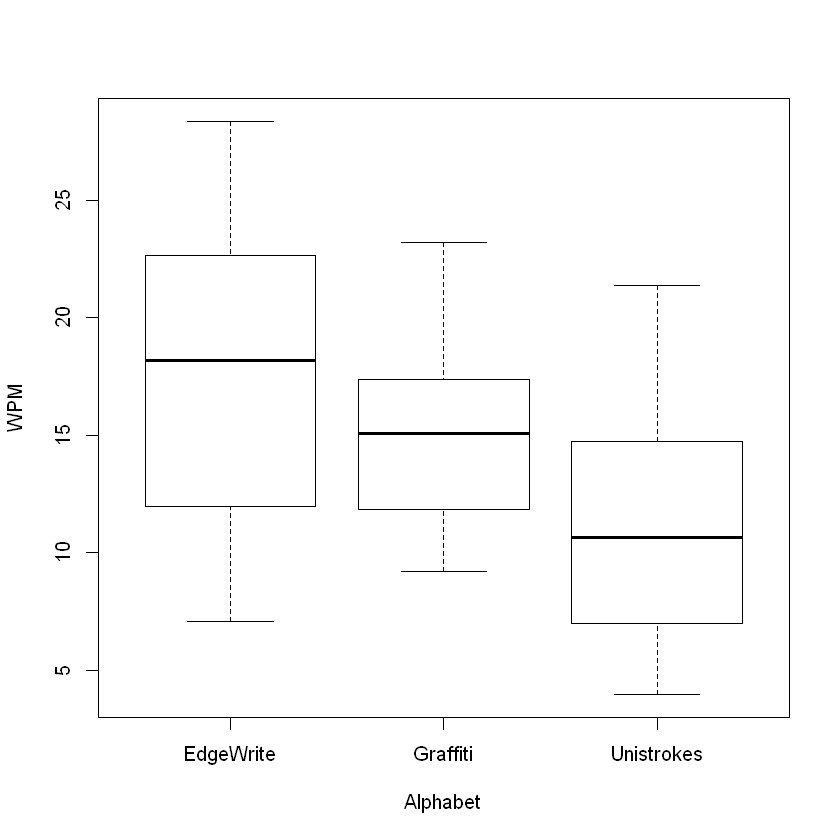

In [76]:
plot(WPM ~ Alphabet, data=df)

To the nearest hundredth (two digits), what was the average text entry speed in words per minute (WPM) of the EdgeWrite alphabet?

In [72]:
library("dplyr")

In [73]:
df %>%
    group_by(Alphabet) %>%
    summarise(avg_WPM = mean(WPM))

Alphabet,avg_WPM
EdgeWrite,17.1400
Graffiti,15.0395
Unistrokes,11.3715


Conduct Shapiro-Wilk normality tests on the WPM response for each Alphabet. Which of the following, if any, violate the normality test? 

In [81]:
edge <- df[df$Alphabet == "EdgeWrite", ]
graf <- df[df$Alphabet == "Graffiti", ]
uni <- df[df$Alphabet == "Unistrokes", ]

In [82]:
shapiro.test(edge$WPM)
shapiro.test(graf$WPM)
shapiro.test(uni$WPM)


	Shapiro-Wilk normality test

data:  edge$WPM
W = 0.95958, p-value = 0.5355



	Shapiro-Wilk normality test

data:  graf$WPM
W = 0.94311, p-value = 0.2743



	Shapiro-Wilk normality test

data:  uni$WPM
W = 0.94042, p-value = 0.2442


Null hypothesis is that the data is normally distributed (no difference from the normal distribution). All 3 are greater than 0.05 so we fail to reject the null hypotheses for all 3. All 3 are normally distributed. 

Conduct a Shapiro-Wilk normality test on the residuals of a WPM by Alphabet model. To the nearest ten-thousandth (four digits), what is the p-value from such a test? Hint: Fit a model with aov and then run shapiro.test on the model residuals.

In [83]:
m <- aov(WPM ~ Alphabet, data=df)
residuals_m <- residuals(m)
shapiro.test(residuals_m)


	Shapiro-Wilk normality test

data:  residuals_m
W = 0.97762, p-value = 0.3363


Conduct a Brown-Forsythe homoscedasticity test on WPM by Alphabet. To the nearest ten-thousandth (four digits), what is the p-value from such a test? Hint: Use the car library and its leveneTest function with center=median.

In [84]:
leveneTest(WPM ~ Alphabet, data=df, center=median) # Brown-Forsythe test

,Df,F value,Pr(>F)
group,2,1.621912,0.206503
,57,NA,NA


Conduct a oneway ANOVA on WPM by Alphabet. To the nearest hundredth (two digits), what is the F statistic from such a test?

In [85]:
m <- aov(WPM ~ Alphabet, data=df)
anova(m)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Alphabet,2,340.9461,170.47306,5.947159,0.004510309
Residuals,57,1633.8834,28.66462,NA,NA


Perform simultaneous pairwise comparisons among levels of Alphabet using the Tukey approach. Adjust for multiple comparisons using Holm's sequential Bonferroni procedure. To the nearest ten-thousandth (four digits), what is the corrected p-value for the comparison of Unistrokes to Graffiti? Hint: Use the multcomp library and its mcp function called from within its glht function.



In [87]:
glh <- glht(m, mcp(Alphabet="Tukey")) # pairwise
summary(glh, test=adjusted(type="holm"))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = WPM ~ Alphabet, data = df)

Linear Hypotheses:
                            Estimate Std. Error t value Pr(>|t|)   
Graffiti - EdgeWrite == 0     -2.100      1.693  -1.241  0.21982   
Unistrokes - EdgeWrite == 0   -5.768      1.693  -3.407  0.00363 **
Unistrokes - Graffiti == 0    -3.668      1.693  -2.166  0.06894 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- holm method)


According to the results of the simultaneous pairwise comparisons, which of the following levels of Alphabet are significantly different in terms of WPM?

* Unistrokes - EdgeWrite

Conduct a Kruskal-Wallis test on WPM by Alphabet. To the nearest ten-thousandth (four digits), what is the p-value from such a test? Hint: Use the coin library and its kruskal_test function with distribution="asymptotic".

In [88]:
kruskal_test(WPM ~ Alphabet, data=df, distribution="asymptotic")


	Asymptotic Kruskal-Wallis Test

data:  WPM by
	 Alphabet (EdgeWrite, Graffiti, Unistrokes)
chi-squared = 9.7019, df = 2, p-value = 0.007821


Conduct nonparametric post hoc pairwise comparisons of WPM among all levels of Alphabet manually using three separate Mann-Whitney U tests. Adjust the p-values using Holm's sequential Bonferroni procedure. To the nearest ten-thousandth (four digits), what is the corrected p-value for Unistrokes vs. Graffiti? Hint: The coin library's wilcox_test only takes a model formula specification. For this, you need wilcox.test with paired=FALSE (and to avoid warnings, exact=FALSE).



In [89]:
edge <- df[df$Alphabet == "EdgeWrite", ]
graf <- df[df$Alphabet == "Graffiti", ]
uni <- df[df$Alphabet == "Unistrokes", ]

In [90]:
edge.graf <- wilcox.test(edge$WPM, graf$WPM, exact=FALSE)
edge.uni <- wilcox.test(edge$WPM, uni$WPM, exact=FALSE)
graf.uni <- wilcox.test(graf$WPM, uni$WPM, exact=FALSE)

res <- c(edge.graf$p.value, edge.uni$p.value, graf.uni$p.value)

p.adjust(res, method="holm")

[1] 0.20358147 0.01810677 0.04146919